# **Clustering**

El primer paso es realizar un análisis de segmentación para agrupar clientes o productos según características clave.

In [34]:
%load_ext autoreload
%autoreload 2


# -----------------------------------------------------------------------
import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append("../../")
from src import funciones_eda as fe
from src import soporte_clustering as sc
from src import funciones_encoding as fen
from src import funciones_outliers as fo
from src import funciones_estandarizacion as fes

pd.set_option("display.max_columns", None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
df = pd.read_csv("../../datos/Global_Superstore.csv", encoding="latin1")
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium


Observamos que no hay dupolicados y la única columna que tiene nulos es Postal Code:

In [36]:
print(f"Hay {df.duplicated().sum()} duplicados.")
df.isna().sum()

Hay 0 duplicados.


Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Vamos a eliminar las columnas que no aportan valor a la hora de segmentar los clientes. Entre ellas la columna que consideramos más importante es `Profit` pues nosotros como empresa lo que vamos a intentar es segmentar a nuestros clientes en base al dinero que nos están generando como empresa.

In [37]:
df_clustering = df[['Segment', 'Market', 'Category', 'Sales', 'Profit', 'Order Priority']]

In [38]:
fe.exploracion_dataframe(df_clustering)

El número de datos es 51290 y el de columnas es 6

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 2332

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Segment,object
Market,object
Category,object
Sales,float64
Profit,float64
Order Priority,object



 ..................... 



,count,mean,std,min,25%,50%,75%,max
Sales,51290.0,246.490581,487.565361,0.444,30.758625,85.053,251.0532,22638.480
Profit,51290.0,28.610982,174.340972,-6599.978,0.000000,9.240,36.8100,8399.976



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna SEGMENT tiene las siguientes valore únicos:


,count
Segment,
Consumer,26518
Corporate,15429
Home Office,9343


La columna MARKET tiene las siguientes valore únicos:


,count
Market,
APAC,11002
LATAM,10294
EU,10000
US,9994
EMEA,5029


La columna CATEGORY tiene las siguientes valore únicos:


,count
Category,
Office Supplies,31273
Technology,10141
Furniture,9876


La columna ORDER PRIORITY tiene las siguientes valore únicos:


,count
Order Priority,
Medium,29433
High,15501
Critical,3932
Low,2424


Podemos observar que han aparecido duplicados debido a que hemos eliminado numerosas columnas, sin embargo, esos duplicados corresponden a datos reales por lo que los mantenemos. 

Vemos que tanto la media como mediana de las variables numéricas difieren bastante siendo en Sales 85 la mediana y 246 la media, lo que implica que hay alguno valores muy muy altos que distorsionan la media, lo mismo ocurre con Profit.

### 1. Visualizar numéricas y categóricas.

In [39]:
sop_clust = sc.Exploracion(df_clustering)

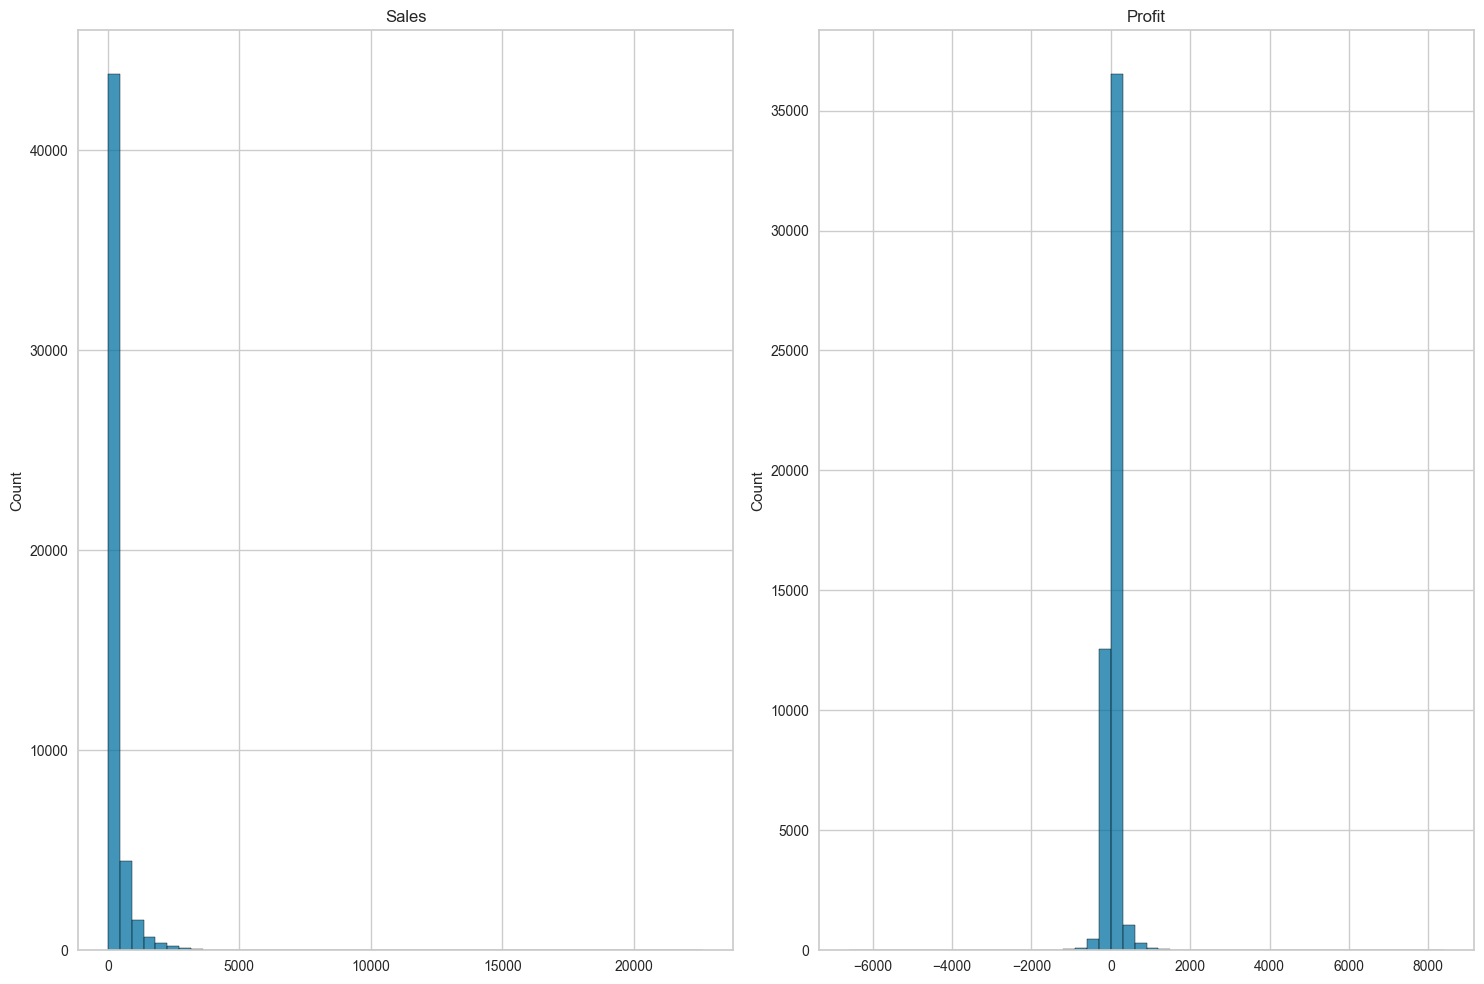

In [40]:
df_num, df_cat = fe.separar_df(df_clustering)
fe.plot_numericas(df_num)

Podemos observar gráficamente lo que acabamos de comentar sobre la media y la mediana y como hay valores donde hay muchísimo más peso que en otras haciendo que la media sea poco fiable.

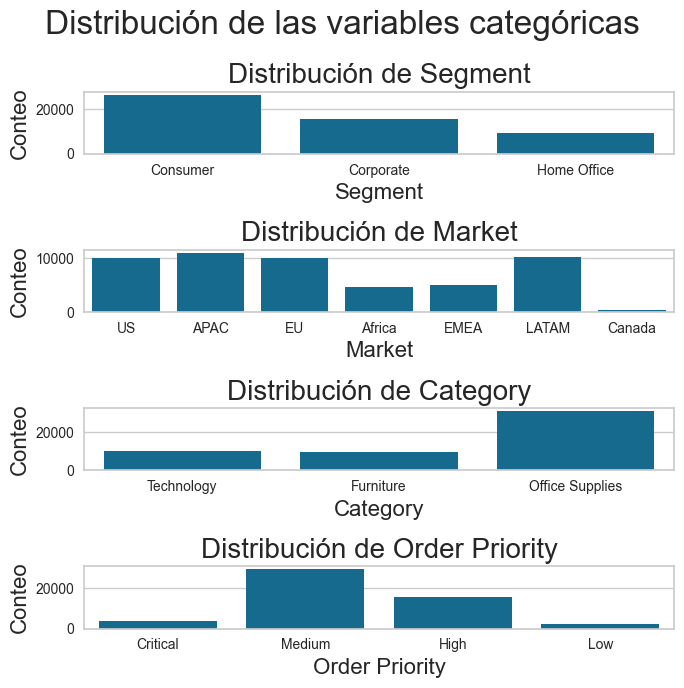

In [41]:
sop_clust.visualizar_categoricas(figsize=(7,7))

En cuanto a las variables categóricas podemos ver que en Segment la variable consumer es la dominante, en cuanto a paises claramente hay muchísimos más clientes de Estados Unidos que de otros paises lo que puede generarnos demasiados clusters debido a sus distintos hábitos de compra. En cuanto a Category la más vendidad es Office Supllies y en cuanto a Order Priority la más usada es medium seguida de high.

### 2. Correlación entre variables numéricas

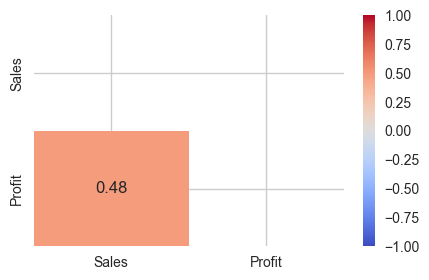

In [42]:
fe.heatmap_correlacion(df_clustering, figsize=(5,3))

La correlación entre Sales y Profit es mediana, de hecho estudiando los datos la categoría que más sales genera es la que menos profit da, no en todas es así, pero es una buena observación para entender porque la correlación no es más alta.

### 3. Outliers

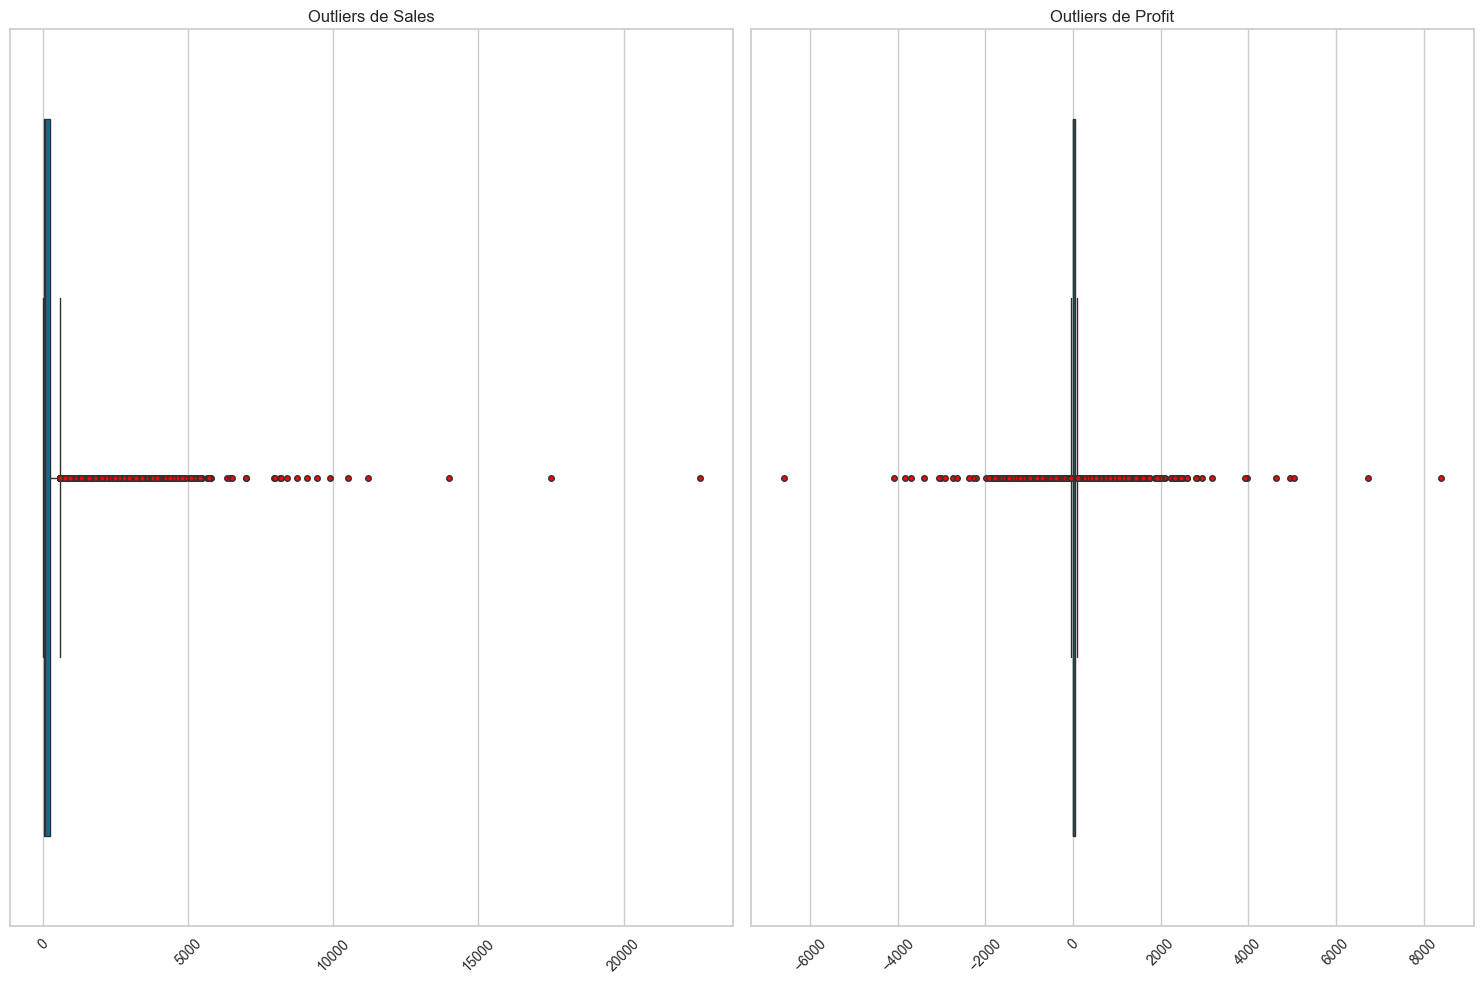

In [43]:
fe.detectar_outliers(df_clustering)

In [44]:
multi = fo.GestionOutliersMultivariados(df_clustering)
contaminacion = [0.01, 0.05, 0.1]
estimadores = [10, 100, 200]
cols = df_num.columns
vr = ""
df_outliers = multi.detectar_outliers_if(cols, vr, contaminacion, estimadores, False)

In [45]:
df_outliers["porcentaje_outliers"] = df_outliers.filter(like="outliers").apply(lambda x: round(sum(x==-1)/len(x),2), axis=1)

porcentaje = 0.6
df_outliers_porcentaje = df_outliers[df_outliers["porcentaje_outliers"]>porcentaje]
df_restante = df_outliers[df_outliers["porcentaje_outliers"]<porcentaje]

print(f"Tenemos un {round(df_outliers_porcentaje.shape[0]/df_outliers.shape[0]*100, 2)}% de outliers respecto al total de los datos.")

Tenemos un 4.46% de outliers respecto al total de los datos.


In [46]:
df_outliers_porcentaje.shape[0]

2289

In [47]:
df_outliers_porcentaje.describe().T[:2]

,count,mean,std,min,25%,50%,75%,max
Sales,2289.0,1737.307585,1307.948010,63.474,959.760,1564.5600,2182.68,22638.480
Profit,2289.0,164.083378,748.850891,-6599.978,-324.864,309.4515,553.98,8399.976


In [48]:
df_outliers_porcentaje["Category"].value_counts()


Category
Technology         946
Furniture          884
Office Supplies    459
Name: count, dtype: int64

Observando los outlies al fin y al cabo son datos reales y tampoco deberíamos eliminarlos a la ligera por lo que como primera aproximación nos los quedamos.

In [50]:
df_inicial = df_clustering.copy()

In [51]:
df_inicial.to_pickle("../../datos/dataframes/df_inicial.pkl")

## **Preprocesamiento**

### Encoding

In [52]:
df_clustering.head(1)

,Segment,Market,Category,Sales,Profit,Order Priority
0,Consumer,US,Technology,2309.65,762.1845,Critical


In [61]:
diccionario_encoding={"onehot":['Category'], "frequency":['Segment', "Profit", 'Market', 'Order Priority']}
var = "Profit"
encoding = fen.Encoding(df_clustering, diccionario_encoding, var)


df_ohe, one_hot_encoder = encoding.one_hot_encoding()
df_ohe.drop(columns=diccionario_encoding["onehot"], inplace=True)
df_ohe

df_scaled = encoding.frequency_encoding()
df_scaled.head(3)


,Segment,Market,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology
0,0.517021,0.194853,2309.650,0.000019,0.076662,0.0,0.0,1.0
1,0.300819,0.214506,3709.395,0.000019,0.076662,1.0,0.0,0.0
2,0.517021,0.214506,5175.171,0.000019,0.573855,0.0,0.0,1.0


In [62]:
df_scaled.to_pickle("../../datos/dataframes/df_clustering_encoded.pkl")

### Estandarizacion

In [63]:
df_clustering_encoded = pd.read_pickle("../../datos/dataframes/df_clustering_encoded.pkl")

In [64]:
modelos_estand = ["standar", "robust", "minmax"]

df_estand, dic_scaler = fes.estandarizacion(df_clustering_encoded, df_clustering_encoded.columns, modelos_estand)
df_estand.head()

,Segment,Market,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology,Segment_standar,Market_standar,Sales_standar,Profit_standar,Order Priority_standar,Category_Furniture_standar,Category_Office Supplies_standar,Category_Technology_standar,Segment_robust,Market_robust,Sales_robust,Profit_robust,Order Priority_robust,Category_Furniture_robust,Category_Office Supplies_robust,Category_Technology_robust,Segment_minmax,Market_minmax,Sales_minmax,Profit_minmax,Order Priority_minmax,Category_Furniture_minmax,Category_Office Supplies_minmax,Category_Technology_minmax
0,0.517021,0.194853,2309.650,0.000019,0.076662,0.0,0.0,1.0,0.924087,0.329872,4.231596,-0.220113,-1.929401,-0.488334,-1.249929,2.014370,0.000000,-0.020000,10.098283,-0.181818,-1.83039,0.0,-1.0,1.0,1.000000,0.905067,0.102006,0.0,0.055833,0.0,0.0,1.0
1,0.300819,0.214506,3709.395,0.000019,0.076662,1.0,0.0,0.0,-0.661092,0.764681,7.102511,-0.220113,-1.929401,2.047779,-1.249929,-0.496433,-1.000000,3.340000,16.452253,-0.181818,-1.83039,1.0,-1.0,0.0,0.354352,1.000000,0.163837,0.0,0.055833,1.0,0.0,0.0
2,0.517021,0.214506,5175.171,0.000019,0.573855,0.0,0.0,1.0,0.924087,0.764681,10.108857,-0.220113,0.795092,-0.488334,-1.249929,2.014370,0.000000,3.340000,23.105962,-0.181818,0.00000,0.0,-1.0,1.0,1.000000,1.000000,0.228586,0.0,1.000000,0.0,0.0,1.0
3,0.182160,0.194970,2892.510,0.000019,0.573855,0.0,0.0,1.0,-1.531089,0.332460,5.427057,-0.220113,0.795092,-0.488334,-1.249929,2.014370,-1.548832,0.000000,12.744104,-0.181818,0.00000,0.0,-1.0,1.0,0.000000,0.905632,0.127753,0.0,1.000000,0.0,0.0,1.0
4,0.517021,0.089433,2832.960,0.000019,0.076662,0.0,0.0,1.0,0.924087,-2.002483,5.304919,-0.220113,-1.929401,-0.488334,-1.249929,2.014370,0.000000,-18.043333,12.473784,-0.181818,-1.83039,0.0,-1.0,1.0,1.000000,0.395837,0.125122,0.0,0.055833,0.0,0.0,1.0


In [65]:
scaler="minmax"
df_scaled = df_estand.loc[:, df_estand.columns.str.contains(f"{scaler}", case=False)]
df_scaled.columns = df_scaled.columns.str.replace(f"_{scaler}", "", regex=False)

df_scaled.head(2)


,Segment,Market,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology
0,1.000000,0.905067,0.102006,0.0,0.055833,0.0,0.0,1.0
1,0.354352,1.000000,0.163837,0.0,0.055833,1.0,0.0,0.0


In [66]:
df_scaled.to_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")

# **Modelos de clustering**

In [67]:
df = pd.read_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")
df_inicial = pd.read_pickle("../../datos/dataframes/df_inicial.pkl")

df.head()

,Segment,Market,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology
0,1.000000,0.905067,0.102006,0.0,0.055833,0.0,0.0,1.0
1,0.354352,1.000000,0.163837,0.0,0.055833,1.0,0.0,0.0
2,1.000000,1.000000,0.228586,0.0,1.000000,0.0,0.0,1.0
3,0.000000,0.905632,0.127753,0.0,1.000000,0.0,0.0,1.0
4,1.000000,0.395837,0.125122,0.0,0.055833,0.0,0.0,1.0


In [68]:
clust = sc.Clustering(df)

Veamos cual es el mejor codo:

In [ ]:
clust.sacar_clusters_kmeans()

Hemos obtenido que el mejor codo es 3, aun así probamos varios valores por encima y po debajo para ver cual es el que mejores métricas nos da.

In [69]:
k=3
df_kmeans, labels = clust.modelo_kmeans(df, k)
display(df_kmeans.head())
clust.calcular_metricas(labels)

,Segment,Market,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology,clusters_kmeans
0,1.000000,0.905067,0.102006,0.0,0.055833,0.0,0.0,1.0,2
1,0.354352,1.000000,0.163837,0.0,0.055833,1.0,0.0,0.0,1
2,1.000000,1.000000,0.228586,0.0,1.000000,0.0,0.0,1.0,2
3,0.000000,0.905632,0.127753,0.0,1.000000,0.0,0.0,1.0,2
4,1.000000,0.395837,0.125122,0.0,0.055833,0.0,0.0,1.0,2


,silhouette_score,davies_bouldin_index,cardinalidad
0,0.609671,0.646521,"{0: 31273, 1: 9876, 2: 10141}"


Obtenemos un silhouette_score de 0.6 cuando el óptio sería 1 y un davies_bouldin_index de 0.6 cuando debería acercarse a 0, por lo que estas métricas no son demasiado buenas, sinembargo podemos ver cada cluster y sus propiedades a ver si tiene sentido.

In [70]:
df_inicial["cluster_kmean"]=df_kmeans["clusters_kmeans"]
df_inicial.head()

,Segment,Market,Category,Sales,Profit,Order Priority,cluster_kmean
0,Consumer,US,Technology,2309.650,762.1845,Critical,2
1,Corporate,APAC,Furniture,3709.395,-288.7650,Critical,1
2,Consumer,APAC,Technology,5175.171,919.9710,Medium,2
3,Home Office,EU,Technology,2892.510,-96.5400,Medium,2
4,Consumer,Africa,Technology,2832.960,311.5200,Critical,2


columna: Segment
columna: Market
columna: Category
columna: Order Priority
columna: cluster_kmean


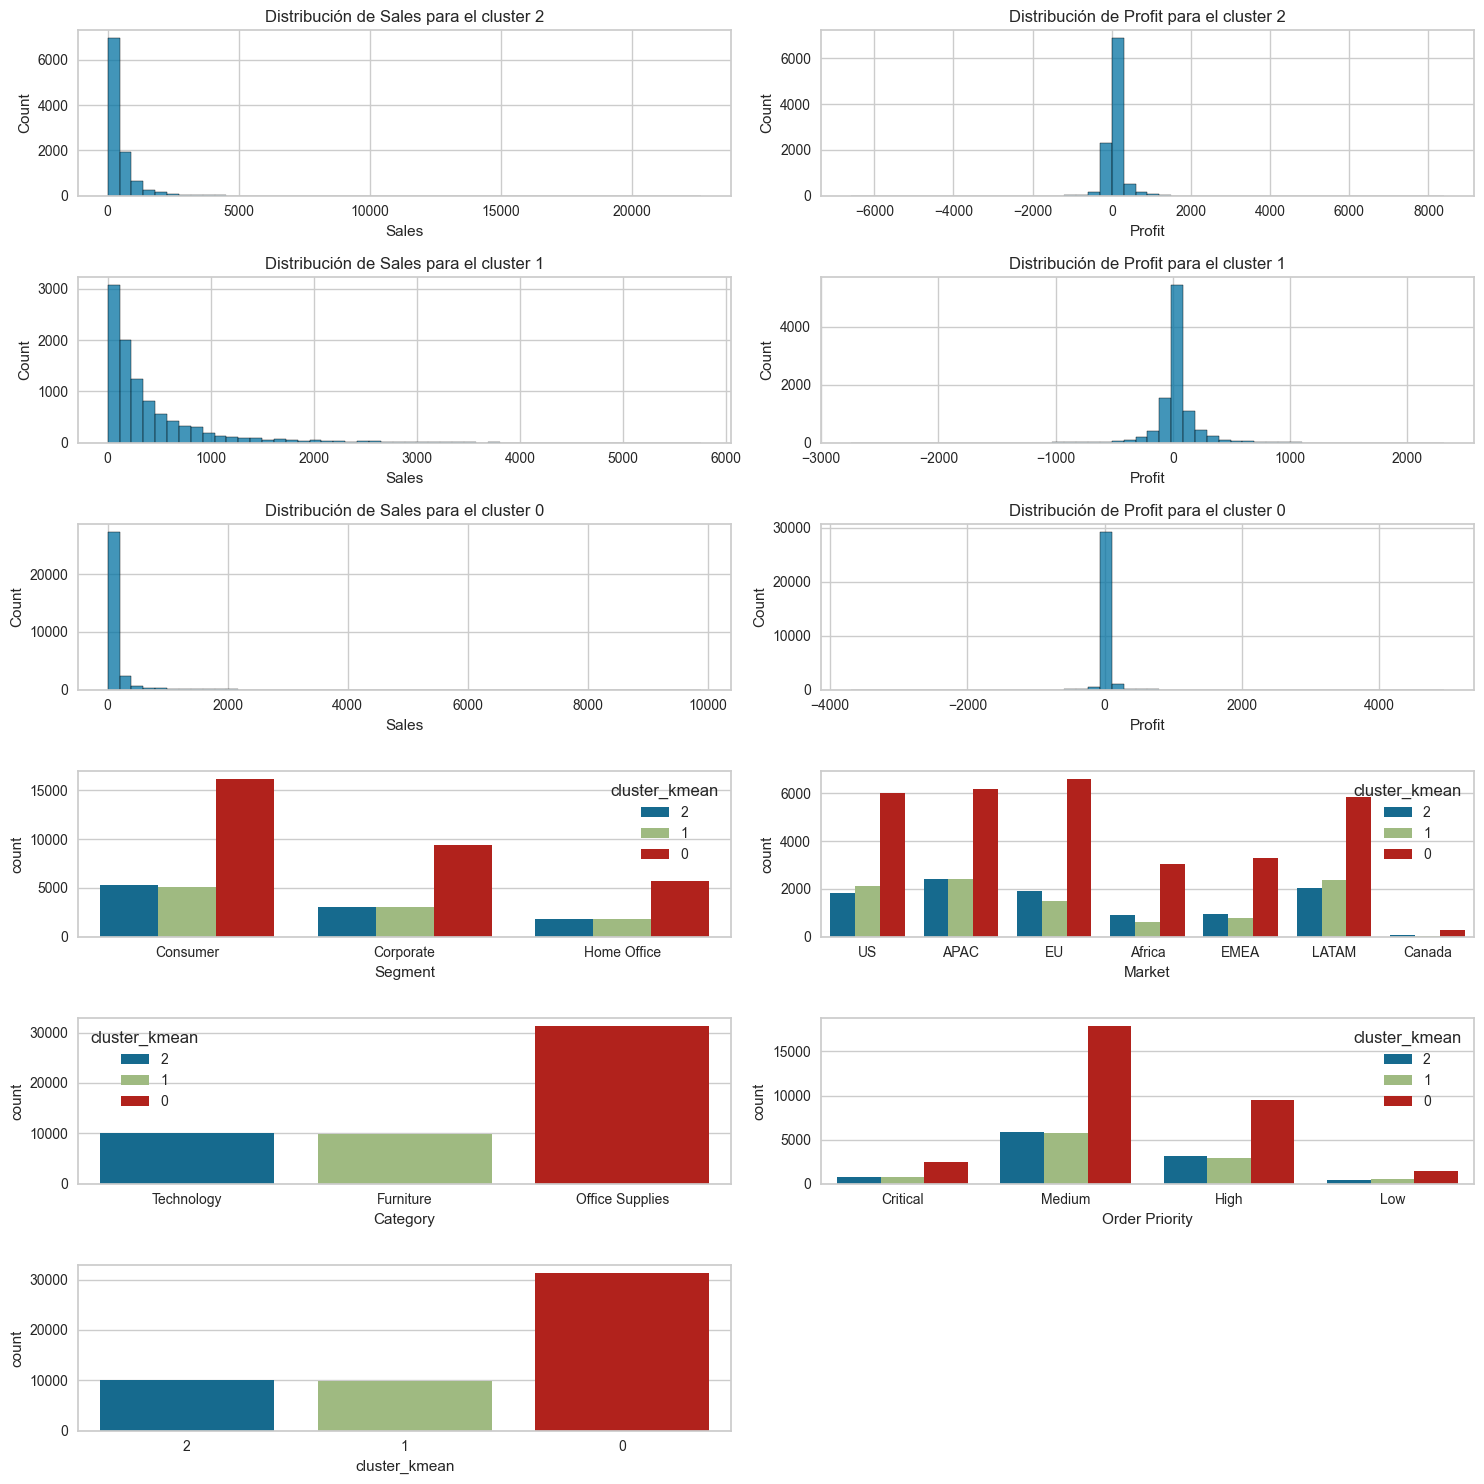

In [71]:
clust.show_cols_clusters(df_inicial, "cluster_kmean")

In [ ]:
for cluster in sorted(df_inicial["cluster_kmean"].unique()):
    print(f"Cluster {cluster}:")
    display(df_inicial[df_inicial["cluster_kmean"]==f"{cluster}"].describe().T)

Cluster 0:


,count,mean,std,min,25%,50%,75%,max
Sales,31273.0,121.097120,299.321405,0.4440,20.34,46.3800,105.24,9892.74
Profit,31273.0,16.578961,109.749251,-3701.8928,0.45,6.5538,20.58,4946.37


Cluster 1:


,count,mean,std,min,25%,50%,75%,max
Sales,10141.0,467.858939,708.972701,0.990,117.15,260.34,554.85,22638.480
Profit,10141.0,65.454958,271.215376,-6599.978,0.50,29.94,98.85,8399.976


Cluster 2:


,count,mean,std,min,25%,50%,75%,max
Sales,9876.0,416.248905,553.066417,1.892,91.026,220.2000,509.265,5759.964
Profit,9876.0,28.878567,205.759936,-2750.280,-12.175,15.5022,69.360,2316.510


El modelo obtenido genera tres clusters {0: 31273, 1: 9876, 2: 10141}.

Los separa principalmente por Category, las demás variables dentro de cada cluster están bastante equilibradas.

En cuanto a Profit de cada cluster si que se observa que el cluster 0 genera profit de -3700 a 5000,
el cluster 1 de -7000 a 8400 y el cluster 2 de -2700 a 2300, aunque el cluster 1 tenga un rango bastante amplio los otros dos sí parecen tener sentido.

# **Aglomerativo**

El tiempo de computación de este modelo para las distintas métricas se dispra muchísimo ya que tenemos 50000 datos, hemos probado alguna combinación y las méstricas y clusters no son much mejores que el anterior.

# **DBSCAN**

In [83]:
df = pd.read_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")
df_inicial = pd.read_pickle("../../datos/dataframes/df_inicial.pkl")

df.head()

,Segment,Market,Sales,Profit,Order Priority,Category_Furniture,Category_Office Supplies,Category_Technology
0,1.000000,0.905067,0.102006,0.0,0.055833,0.0,0.0,1.0
1,0.354352,1.000000,0.163837,0.0,0.055833,1.0,0.0,0.0
2,1.000000,1.000000,0.228586,0.0,1.000000,0.0,0.0,1.0
3,0.000000,0.905632,0.127753,0.0,1.000000,0.0,0.0,1.0
4,1.000000,0.395837,0.125122,0.0,0.055833,0.0,0.0,1.0


In [84]:
cluster = sc.Clustering(df)

In [87]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[0.5, 1.0], min_samples_values=[500, 1000, 2000, 5000])

100%|██████████| 4/4 [05:50<00:00, 87.54s/it]


,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality,num_clusters
0,0.5,500,0.557396,0.865308,"{-1: 676, 0: 2312, 1: 1967, 2: 2903, 3: 2861, ...",13
1,0.5,1000,0.551542,1.168239,"{-1: 1039, 0: 2311, 1: 1825, 2: 2903, 3: 2861,...",13
5,1.0,1000,0.541974,0.797565,"{0: 10141, 1: 9876, 2: 31273}",3
4,1.0,500,0.541974,0.797565,"{0: 10141, 1: 9876, 2: 31273}",3
6,1.0,2000,0.541974,0.797565,"{0: 10141, 1: 9876, 2: 31273}",3
7,1.0,5000,0.536653,1.006057,"{-1: 10, 0: 10134, 1: 9873, 2: 31273}",4
2,0.5,2000,0.455721,1.052133,"{-1: 7451, 0: 2903, 1: 2582, 2: 6238, 3: 6908,...",10
3,0.5,5000,0.257055,1.207909,"{-1: 28335, 0: 6169, 1: 9009, 2: 7777}",4


best_eps: 0.5, best_min_samples: 500


In [95]:
df = pd.read_pickle("../../datos/dataframes/df_clustering_encoded_scaled.pkl")
cluster = sc.Clustering(df)

df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[1.0], min_samples_values=[1000])

100%|██████████| 1/1 [01:19<00:00, 79.66s/it]


,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality,num_clusters
0,1.0,1000,0.541974,0.797565,"{0: 10141, 1: 9876, 2: 31273}",3


best_eps: 1.0, best_min_samples: 1000


In [96]:
df_inicial["clusters_dbscan"]=df_cluster_dbscan["clusters_dbscan"]
df_inicial.head()

,Segment,Market,Category,Sales,Profit,Order Priority,clusters_dbscan
0,Consumer,US,Technology,2309.650,762.1845,Critical,0
1,Corporate,APAC,Furniture,3709.395,-288.7650,Critical,1
2,Consumer,APAC,Technology,5175.171,919.9710,Medium,0
3,Home Office,EU,Technology,2892.510,-96.5400,Medium,0
4,Consumer,Africa,Technology,2832.960,311.5200,Critical,0


columna: Segment
columna: Market
columna: Category
columna: Order Priority


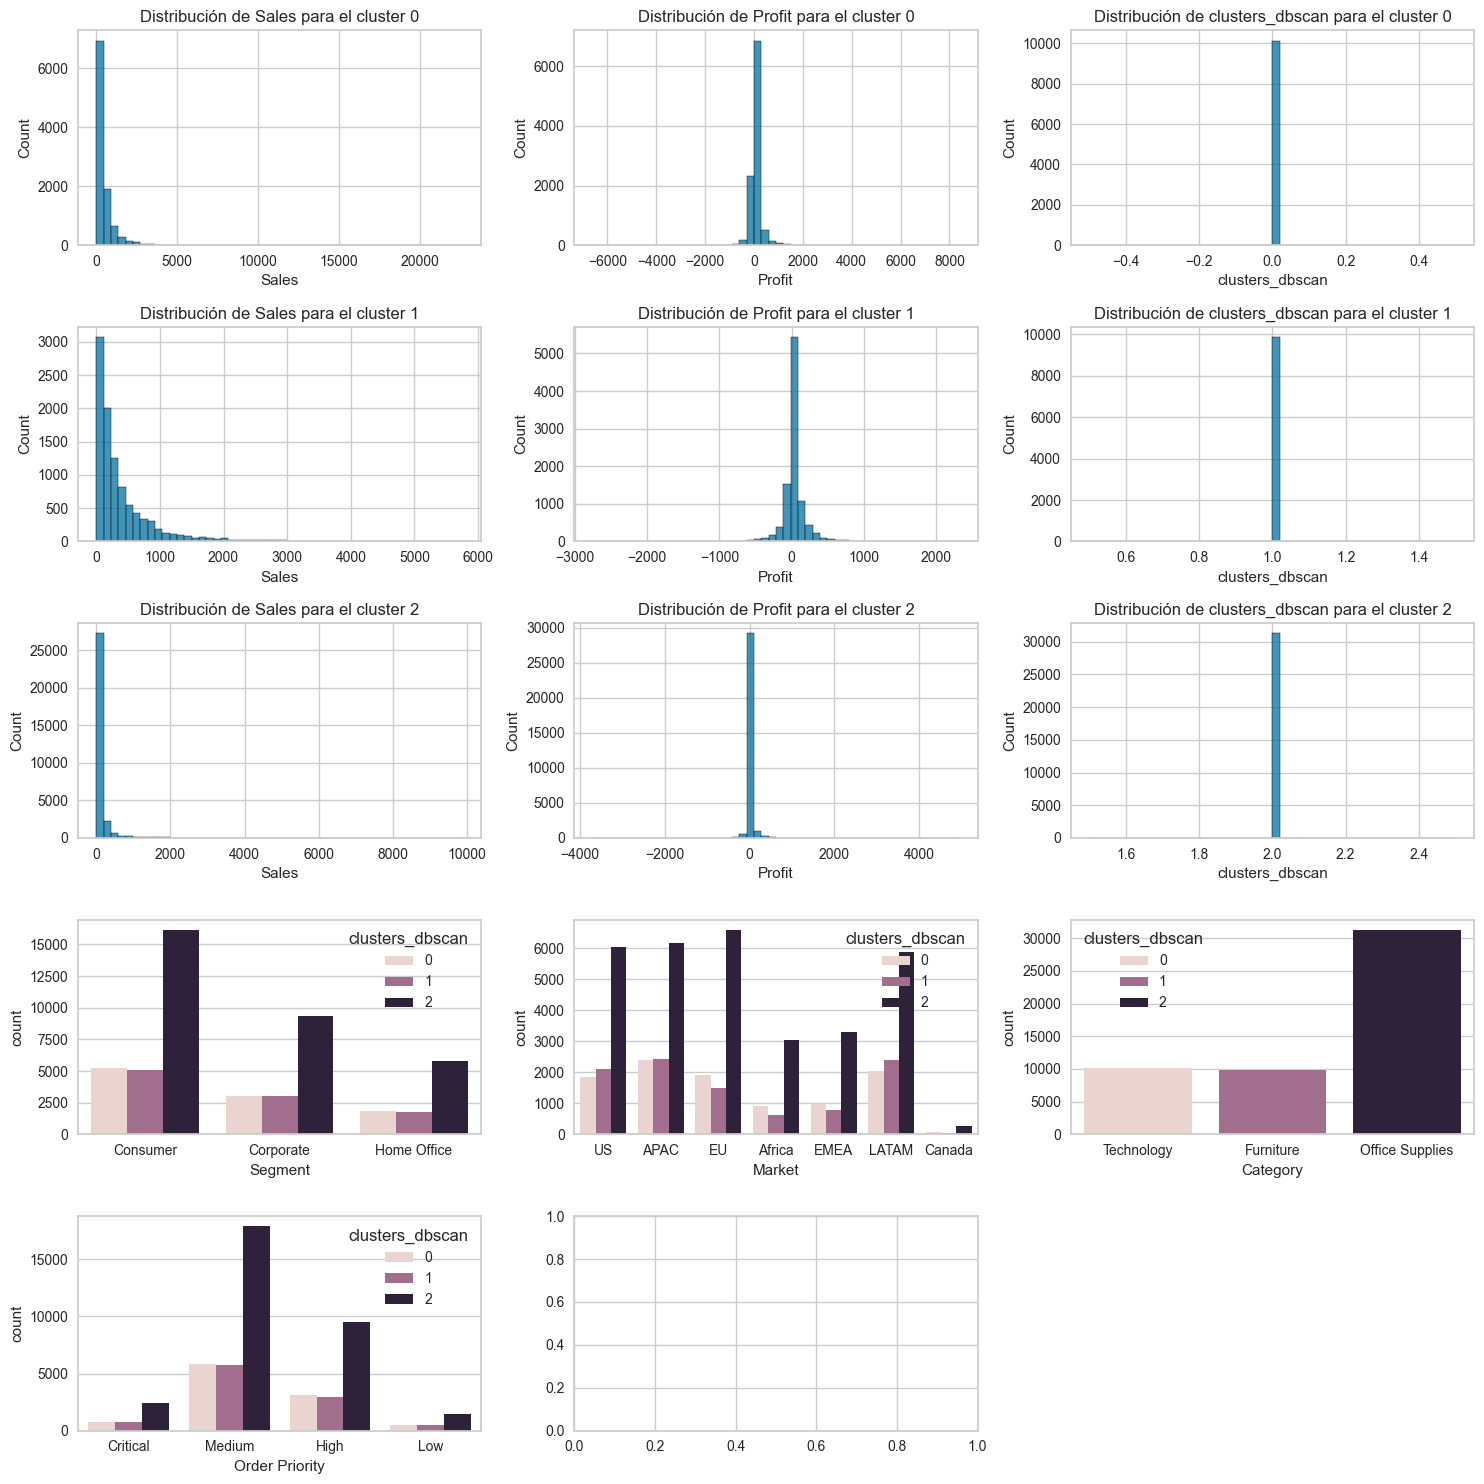

In [97]:
cluster.show_cols_clusters(df_inicial, "clusters_dbscan")

In [99]:
for cluster in sorted(df_inicial["clusters_dbscan"].unique()):
    print(f"Cluster {cluster}:")
    display(df_inicial[df_inicial["clusters_dbscan"]==cluster].describe().T)

Cluster 0:


,count,mean,std,min,25%,50%,75%,max
Sales,10141.0,467.858939,708.972701,0.990,117.15,260.34,554.85,22638.480
Profit,10141.0,65.454958,271.215376,-6599.978,0.50,29.94,98.85,8399.976
clusters_dbscan,10141.0,0.000000,0.000000,0.000,0.00,0.00,0.00,0.000


Cluster 1:


,count,mean,std,min,25%,50%,75%,max
Sales,9876.0,416.248905,553.066417,1.892,91.026,220.2000,509.265,5759.964
Profit,9876.0,28.878567,205.759936,-2750.280,-12.175,15.5022,69.360,2316.510
clusters_dbscan,9876.0,1.000000,0.000000,1.000,1.000,1.0000,1.000,1.000


Cluster 2:


,count,mean,std,min,25%,50%,75%,max
Sales,31273.0,121.097120,299.321405,0.4440,20.34,46.3800,105.24,9892.74
Profit,31273.0,16.578961,109.749251,-3701.8928,0.45,6.5538,20.58,4946.37
clusters_dbscan,31273.0,2.000000,0.000000,2.0000,2.00,2.0000,2.00,2.00
